In [1]:
!pip install -q penaltyblog

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 26.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 85.6 MB/s eta 0:00:00:00:0100:01


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import defaultdict, deque
import penaltyblog as pb

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# df = pd.read_csv('/kaggle/input/midblock/lengkap_v1_with elo.csv')

# df.info()

In [4]:
df = pd.read_csv('/kaggle/input/midblock/raw_v1.csv')

df

,match_id,match_date,team_home_id,homeTeam_name,team_away_id,awayTeam_name,home_goals,away_goals,match_id_1,possession_home,...,shotmap_xg_away,avg_rating_home,weighted_rating_home,xG_from_players_home,goal_contrib_home,avg_rating_away,weighted_rating_away,xG_from_players_away,goal_contrib_away,result
0,12654006,2025-04-13,86576,Persita Tangerang,86542,PS Barito Putera,2.0,1.0,12654006.0,46.0,...,2.439318,4.234783,7.026037,1.07,4.0,4.500000,6.978912,2.43,1.0,H
1,12654007,2025-04-12,200020,Persis Solo,491968,Malut United FC,1.0,3.0,12654007.0,56.0,...,2.168087,4.013043,6.611045,1.02,2.0,4.595652,7.125904,2.16,5.0,A
2,12653997,2025-04-12,64295,Persija Jakarta,76319,Persebaya Surabaya,1.0,1.0,12653997.0,64.0,...,0.207580,4.666667,7.039712,1.15,1.0,4.655000,6.715856,0.20,2.0,D
3,12654003,2025-04-11,189471,PSIS Semarang,135866,Persik Kediri,0.0,0.0,12654003.0,48.0,...,0.902606,4.495652,6.984669,1.50,0.0,4.290000,7.166433,0.90,0.0,D
4,12654000,2025-04-11,266861,PSBS Biak,204733,PSS Sleman,2.0,1.0,12654000.0,55.0,...,1.035212,4.795455,7.068050,2.77,2.0,5.621053,6.771042,1.03,1.0,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,12652785,2024-08-11,76319,Persebaya Surabaya,204733,PSS Sleman,1.0,0.0,12652785.0,57.0,...,0.182330,7.161538,7.207466,1.80,1.0,5.320000,6.688168,0.28,0.0,H
247,12652783,2024-08-10,135864,PSM Makassar,200020,Persis Solo,3.0,0.0,12652783.0,45.0,...,0.707948,4.960870,7.270937,2.22,5.0,4.586957,6.592483,0.71,0.0,H
248,12652782,2024-08-10,86578,Madura United FC,491968,Malut United FC,1.0,1.0,12652782.0,60.0,...,2.345915,4.682609,6.735138,1.49,1.0,4.630435,6.685841,2.33,1.0,D
249,12652781,2024-08-10,64295,Persija Jakarta,86542,PS Barito Putera,3.0,0.0,12652781.0,57.0,...,0.635869,4.900000,7.181268,2.06,4.0,4.522727,6.611090,0.62,0.0,H


In [5]:
print("Sebelum:", df.shape)
df = df.dropna(subset=['home_goals', 'away_goals'])
print("Sesudah:", df.shape)

Sebelum: (251, 44)
Sesudah: (248, 44)


In [6]:
df['match_date'] = pd.to_datetime(df['match_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 248 entries, 0 to 250
Data columns (total 44 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   match_id              248 non-null    int64         
 1   match_date            248 non-null    datetime64[ns]
 2   team_home_id          248 non-null    int64         
 3   homeTeam_name         248 non-null    object        
 4   team_away_id          248 non-null    int64         
 5   awayTeam_name         248 non-null    object        
 6   home_goals            248 non-null    float64       
 7   away_goals            248 non-null    float64       
 8   match_id_1            243 non-null    float64       
 9   possession_home       243 non-null    float64       
 10  possession_away       243 non-null    float64       
 11  passes_home           243 non-null    float64       
 12  passes_away           243 non-null    float64       
 13  accuratePasses_home   243

/tmp/ipykernel_35/886109718.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['match_date'] = pd.to_datetime(df['match_date'])


# Feature Engineering

## league point & last 5 match point

In [7]:
from collections import defaultdict, deque

# Step 1: Konversi dan urutkan
df['match_date'] = pd.to_datetime(df['match_date'])
df = df.sort_values('match_date').reset_index(drop=True)

# Step 2: Inisialisasi histori
history = defaultdict(lambda: deque(maxlen=5))
total_points = defaultdict(int)

# Step 3: Placeholder buat fitur
point_last5_home = []
point_last5_away = []
league_point_home = []
league_point_away = []

# Step 4: Fungsi konversi hasil ke poin
def result_to_point(result, is_home):
    if result == 'D':
        return 1
    elif result == 'H' and is_home:
        return 3
    elif result == 'A' and not is_home:
        return 3
    else:
        return 0

# Step 5: Looping tiap match
for _, row in df.iterrows():
    home_id = row['team_home_id']
    away_id = row['team_away_id']
    result = row['result']

    # LAST 5 POINTS
    point_last5_home.append(sum(history[home_id]))
    point_last5_away.append(sum(history[away_id]))

    # LEAGUE POINTS
    league_point_home.append(total_points[home_id])
    league_point_away.append(total_points[away_id])

    # Update history
    history[home_id].append(result_to_point(result, is_home=True))
    history[away_id].append(result_to_point(result, is_home=False))

    # Update league total
    total_points[home_id] += result_to_point(result, is_home=True)
    total_points[away_id] += result_to_point(result, is_home=False)

# Step 6: Tambahin kolom ke dataframe
df['point_last5_home'] = point_last5_home
df['point_last5_away'] = point_last5_away
df['leaguePoint_home'] = league_point_home
df['leaguePoint_away'] = league_point_away

# Step 7: Balikin urutan ke DESC (opsional buat analisis)
df = df.sort_values('match_date', ascending=False).reset_index(drop=True)

df[['match_id', 'homeTeam_name', 'awayTeam_name', 'match_date', 'point_last5_home','point_last5_away', 'leaguePoint_home', 'leaguePoint_away']]

/tmp/ipykernel_35/2753216074.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['match_date'] = pd.to_datetime(df['match_date'])


,match_id,homeTeam_name,awayTeam_name,match_date,point_last5_home,point_last5_away,leaguePoint_home,leaguePoint_away
0,12654006,Persita Tangerang,PS Barito Putera,2025-04-13,1,7,36,29
1,12654007,Persis Solo,Malut United FC,2025-04-12,9,11,23,43
2,12653997,Persija Jakarta,Persebaya Surabaya,2025-04-12,1,10,40,48
3,12654003,PSIS Semarang,Persik Kediri,2025-04-11,3,3,24,35
4,12654000,PSBS Biak,PSS Sleman,2025-04-11,8,3,37,25
...,...,...,...,...,...,...,...,...
243,12652786,PSIS Semarang,Persita Tangerang,2024-08-11,0,0,0,0
244,12652781,Persija Jakarta,PS Barito Putera,2024-08-10,0,0,0,0
245,12652783,PSM Makassar,Persis Solo,2024-08-10,0,0,0,0
246,12652782,Madura United FC,Malut United FC,2024-08-10,0,0,0,0


In [8]:
team_to_island = {
    'Persib Bandung': 'Jawa',
    'Persija Jakarta': 'Jawa',
    'PSIS Semarang': 'Jawa',
    'PSS Sleman': 'Jawa',
    'Persik Kediri': 'Jawa',
    'Arema FC': 'Jawa',
    'Persebaya Surabaya': 'Jawa',
    'Persis Solo': 'Jawa',
    'Dewa United FC': 'Jawa',
    'PS Barito Putera': 'Kalimantan',
    'Borneo FC Samarinda': 'Kalimantan',
    'PSBS Biak': 'Papua',
    'Malut United FC': 'Maluku',
    'PSM Makassar': 'Sulawesi',
    'Bali United FC': 'Bali',
    'Madura United FC': 'Jawa',
    'Semen Padang FC': 'Sumatra',
    'Persita Tangerang': 'Jawa',
}

df['venue_island'] = df['homeTeam_name'].map(team_to_island)


#venue distance (km)
team_locations = {
    'Persib Bandung': (-6.9147, 107.6098),     # Bandung
    'Persija Jakarta': (-6.2088, 106.8456),    # Jakarta
    'PSIS Semarang': (-6.9667, 110.4167),      # Semarang
    'PSS Sleman': (-7.7167, 110.3167),         # Sleman
    'Arema FC': (-8.1030, 112.6265),           # Malang
    'Persebaya Surabaya': (-7.2575, 112.7521), # Surabaya
    'Bali United FC': (-8.4095, 115.1889),     # Bali
    'PSM Makassar': (-5.1477, 119.4327),       # Makassar
    'Borneo FC Samarinda': (0.5022, 117.1537), # Samarinda
    'PSBS Biak': (-1.1780, 136.2633),          # Biak, Papua
    'PS Barito Putera': (-3.3194, 114.5907),   # Banjarmasin
    'Semen Padang FC': (-0.9246, 100.3658),    # Padang
    'Malut United FC': (1.4834, 127.6402),     # Sofifi, Maluku Utara
    'Dewa United FC': (-6.2568, 106.6189),     # Tangerang Selatan
    'Madura United FC': (-7.0891, 113.2408),   # Pamekasan, Madura
    'Persita Tangerang': (-6.1783, 106.6319),  # Tangerang
    'Persik Kediri': (-7.8161, 112.0113),      # Kediri
    'Persis Solo': (-7.5693, 110.8161),        # Surakarta
}

from math import radians, sin, cos, sqrt, atan2

def haversine(coord1, coord2):
    R = 6371  # Radius bumi dalam km
    lat1, lon1 = coord1
    lat2, lon2 = coord2

    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)

    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

def get_distance(row):
    home = team_locations.get(row['homeTeam_name'])
    away = team_locations.get(row['awayTeam_name'])
    if home and away:
        return haversine(home, away)
    else:
        return None

df['venue_distance_km'] = df.apply(get_distance, axis=1)


df[['homeTeam_name', 'awayTeam_name','venue_island', 'venue_distance_km']]

,homeTeam_name,awayTeam_name,venue_island,venue_distance_km
0,Persita Tangerang,PS Barito Putera,Jawa,937.391318
1,Persis Solo,Malut United FC,Jawa,2120.312763
2,Persija Jakarta,Persebaya Surabaya,Jawa,662.571783
3,PSIS Semarang,Persik Kediri,Jawa,199.597101
4,PSBS Biak,PSS Sleman,Papua,2965.216902
...,...,...,...,...
243,PSIS Semarang,Persita Tangerang,Jawa,427.172584
244,Persija Jakarta,PS Barito Putera,Jawa,916.315735
245,PSM Makassar,Persis Solo,Sulawesi,989.486553
246,Madura United FC,Malut United FC,Jawa,1860.457150


In [9]:
missing_teams = df[~df['homeTeam_name'].isin(team_to_island.keys())]['homeTeam_name'].unique()
print(missing_teams)


[]


In [10]:
df['venue_island'].unique()

array(['Jawa', 'Papua', 'Kalimantan', 'Sulawesi', 'Bali', 'Maluku',
       'Sumatra'], dtype=object)

In [11]:
df['homeTeam_name'].unique()

array(['Persita Tangerang', 'Persis Solo', 'Persija Jakarta',
       'PSIS Semarang', 'PSBS Biak', 'Borneo FC Samarinda',
       'PSM Makassar', 'Bali United FC', 'Madura United FC', 'Arema FC',
       'Malut United FC', 'Persebaya Surabaya', 'PSS Sleman',
       'Persik Kediri', 'Dewa United FC', 'Semen Padang FC',
       'PS Barito Putera', 'Persib Bandung'], dtype=object)

In [12]:
df['awayTeam_name'].unique()

array(['PS Barito Putera', 'Malut United FC', 'Persebaya Surabaya',
       'Persik Kediri', 'PSS Sleman', 'Persib Bandung', 'Semen Padang FC',
       'Dewa United FC', 'Persija Jakarta', 'Madura United FC',
       'Persita Tangerang', 'PSIS Semarang', 'Persis Solo', 'PSBS Biak',
       'PSM Makassar', 'Borneo FC Samarinda', 'Arema FC',
       'Bali United FC'], dtype=object)

## pi rating

In [13]:
# Sort dataframe by date ascending biar urutan match sesuai kronologi
df = df.sort_values("match_date").reset_index(drop=True)

df.head()

,match_id,match_date,team_home_id,homeTeam_name,team_away_id,awayTeam_name,home_goals,away_goals,match_id_1,possession_home,...,weighted_rating_away,xG_from_players_away,goal_contrib_away,result,point_last5_home,point_last5_away,leaguePoint_home,leaguePoint_away,venue_island,venue_distance_km
0,12652779,2024-08-09,64289,Persib Bandung,266861,PSBS Biak,4.0,1.0,12652779.0,40.0,...,6.619903,1.10,2.0,H,0,0,0,0,Jawa,3240.072073
1,12652781,2024-08-10,64295,Persija Jakarta,86542,PS Barito Putera,3.0,0.0,12652781.0,57.0,...,6.611090,0.62,0.0,H,0,0,0,0,Jawa,916.315735
2,12652782,2024-08-10,86578,Madura United FC,491968,Malut United FC,1.0,1.0,12652782.0,60.0,...,6.685841,2.33,1.0,D,0,0,0,0,Jawa,1860.457150
3,12652783,2024-08-10,135864,PSM Makassar,200020,Persis Solo,3.0,0.0,12652783.0,45.0,...,6.592483,0.71,0.0,H,0,0,0,0,Sulawesi,989.486553
4,12652785,2024-08-11,76319,Persebaya Surabaya,204733,PSS Sleman,1.0,0.0,12652785.0,57.0,...,6.688168,0.28,0.0,H,0,0,0,0,Jawa,273.306306


In [14]:
df[df['home_goals'].isna() | df['away_goals'].isna()]

,match_id,match_date,team_home_id,homeTeam_name,team_away_id,awayTeam_name,home_goals,away_goals,match_id_1,possession_home,...,weighted_rating_away,xG_from_players_away,goal_contrib_away,result,point_last5_home,point_last5_away,leaguePoint_home,leaguePoint_away,venue_island,venue_distance_km


In [15]:
# Inisialisasi sistem rating
pi_ratings = pb.ratings.PiRatingSystem()

# Buat list buat simpan rating sebelum pertandingan
pi_home_ratings = []
pi_away_ratings = []

# Looping per match
for idx, row in df.iterrows():
    home_team = row["homeTeam_name"]
    away_team = row["awayTeam_name"]
    goal_diff = row["home_goals"] - row["away_goals"]
    match_date = row["match_date"]

    # Simpan rating sebelum match
    pi_home_ratings.append(pi_ratings.get_team_rating(home_team))
    pi_away_ratings.append(pi_ratings.get_team_rating(away_team))

    # Update rating berdasarkan hasil match
    pi_ratings.update_ratings(home_team, away_team, goal_diff, match_date)

# Masukkan hasil rating ke kolom baru
df["pi_rating_home"] = pi_home_ratings
df["pi_rating_away"] = pi_away_ratings

# Balikin lagi ke urutan match_date DESCENDING (terbaru dulu)
df = df.sort_values('match_date', ascending=False).reset_index(drop=True)

df[['match_id', 'homeTeam_name', 'awayTeam_name', 'match_date', 'point_last5_home','point_last5_away', 'pi_rating_home', 'pi_rating_away']]

,match_id,homeTeam_name,awayTeam_name,match_date,point_last5_home,point_last5_away,pi_rating_home,pi_rating_away
0,12654006,Persita Tangerang,PS Barito Putera,2025-04-13,1,7,-0.195651,-0.102359
1,12654007,Persis Solo,Malut United FC,2025-04-12,9,11,-0.195487,0.340124
2,12653997,Persija Jakarta,Persebaya Surabaya,2025-04-12,1,10,0.040962,0.092979
3,12654003,PSIS Semarang,Persik Kediri,2025-04-11,3,3,-0.349868,-0.158247
4,12654000,PSBS Biak,PSS Sleman,2025-04-11,8,3,0.083611,-0.414688
...,...,...,...,...,...,...,...,...
243,12652787,Persik Kediri,Bali United FC,2024-08-11,0,0,0.000000,0.000000
244,12652782,Madura United FC,Malut United FC,2024-08-10,0,0,0.000000,0.000000
245,12652781,Persija Jakarta,PS Barito Putera,2024-08-10,0,0,0.000000,0.000000
246,12652783,PSM Makassar,Persis Solo,2024-08-10,0,0,0.000000,0.000000


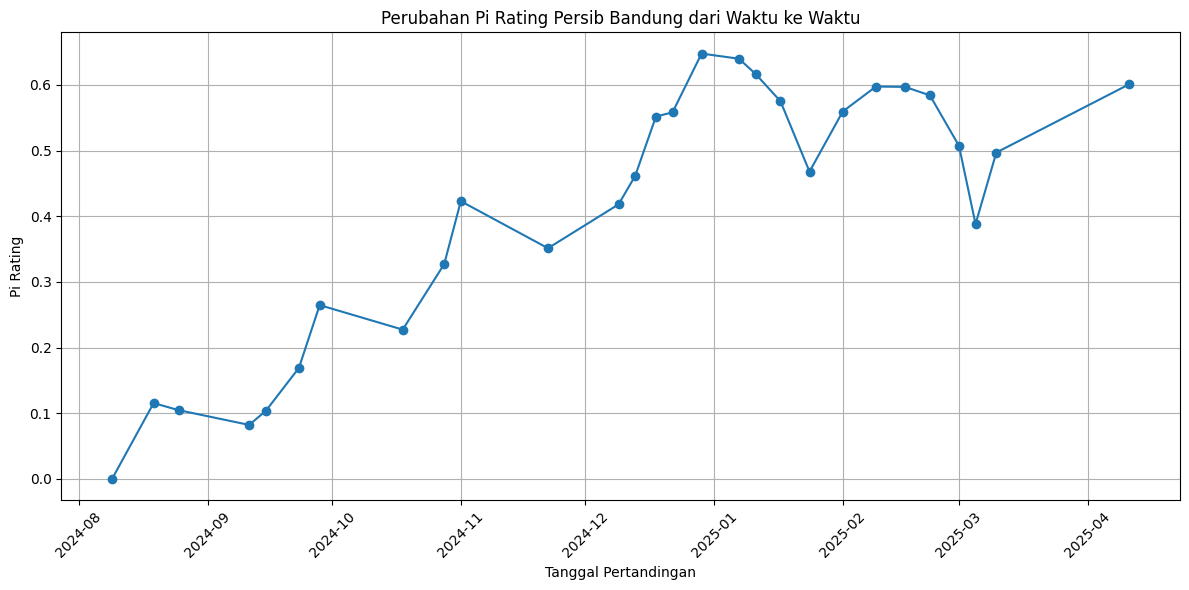

In [16]:
team_name = "Persib Bandung"

# Ambil semua match yang melibatkan tim tersebut
df_team = df[(df['homeTeam_name'] == team_name) | (df['awayTeam_name'] == team_name)].copy()

# Urutkan berdasarkan tanggal pertandingan
df_team = df_team.sort_values('match_date').reset_index(drop=True)

# Buat kolom rating yang menyatukan home dan away
df_team['pi_rating'] = df_team.apply(
    lambda row: row['pi_rating_home'] if row['homeTeam_name'] == team_name else row['pi_rating_away'],
    axis=1
)

plt.figure(figsize=(12,6))
plt.plot(df_team['match_date'], df_team['pi_rating'], marker='o', linestyle='-')
plt.title(f'Perubahan Pi Rating {team_name} dari Waktu ke Waktu')
plt.xlabel('Tanggal Pertandingan')
plt.ylabel('Pi Rating')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


# EDA

## home advantage
Home advantage dalam pertandingan sepak bola (dan olahraga lainnya juga) adalah keuntungan yang secara statistik dimiliki tim tuan rumah saat bermain di kandangnya sendiri. Jadi, secara singkat:

Home advantage = keunggulan performa yang dimiliki tim saat bermain di kandang sendiri dibandingkan saat bermain tandang.

🔍 Kenapa bisa ada home advantage?
- Dukungan Penonton Lokal:
Suporter yang memenuhi stadion bisa ngasih boost moral besar banget ke pemain. Seruan, chant, bahkan tekanan psikologis ke lawan juga ngaruh.

- Lingkungan yang Familiar:
Pemain tuan rumah lebih familiar sama kondisi lapangan, jenis rumput, cuaca, bahkan ruang ganti.

- Perjalanan Lebih Ringan:
Tim kandang gak perlu capek-capek traveling jauh. Tim tandang biasanya datang dari kota/negara lain → bisa capek & jetlag.

- Keputusan Wasit Bisa Bias:
Ini agak kontroversial, tapi beberapa studi nunjukin wasit cenderung ngasih keputusan yang lebih "ramah" ke tuan rumah karena tekanan dari suporter.

- Taktik & Strategi Lebih Optimal:
Pelatih bisa lebih bebas ngatur strategi karena tahu kondisi kandang, bahkan kadang lapangan punya ukuran sedikit beda dari lapangan lain.

📊 Bukti Statistiknya?
Secara global, tim tuan rumah cenderung menang sekitar 50–60% dari pertandingan (tergantung liga dan levelnya).

Misalnya di Liga Inggris:

- Rata-rata kemenangan home: ~45-50%

- Draw: ~25-30%

- Away win: ~20-25%

Surprisingly, and despite over 25 years of research, the precise causes of home advan-tage and the way in which they operate are still not well un-derstood. A review of the evidence for and against plausible explanations needs to be set against a background of the fol-lowing basic facts. Home advantage has been in existence at least since the start of organized football at the end of the 19th century. It is a worldwide phenomenon, but varies con-siderably from country to country. It has declined in the ma-jor leagues in Europe over the last 15 years. It tends to be greater in football than in other team sports.

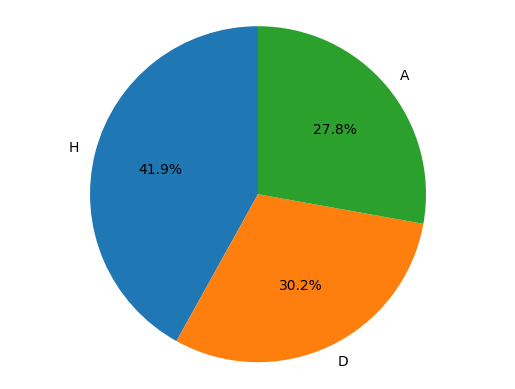

result
H    104
D     69
A     75
Name: count, dtype: int64


In [17]:
fig1, ax1 = plt.subplots()
ax1.pie(df['result'].value_counts(), labels = ["H","D","A"], startangle=90, autopct='%.1f%%', shadow=False)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

result_counts = df['result'].value_counts().reindex(["H", "D", "A"])
print(result_counts)

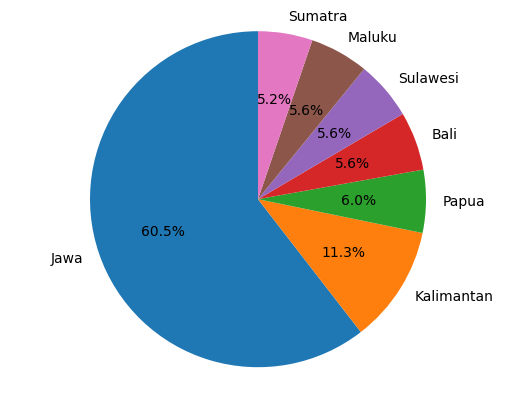

venue_island
Jawa          150
Kalimantan     28
Papua          13
Bali           15
Sulawesi       14
Maluku         14
Sumatra        14
Name: count, dtype: int64


In [18]:
fig1, ax1 = plt.subplots()
ax1.pie(df['venue_island'].value_counts(), labels = ['Jawa', 'Kalimantan', 'Papua', 'Bali', 'Sulawesi', 'Maluku',
       'Sumatra'], startangle=90, autopct='%.1f%%', shadow=False)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

result_counts = df['venue_island'].value_counts().reindex(['Jawa', 'Kalimantan', 'Papua', 'Bali', 'Sulawesi', 'Maluku',
       'Sumatra'])
print(result_counts)

# TEAM PLAYSTYLE

In [19]:
dfp = pd.read_csv('/kaggle/input/midblock/team_playstyle_gw28.csv')
dfp = dfp.set_index('Team Name')
dfp.head()

,Total Matches,Accurate Cross,Accurate Keeper Sweeper,Accurate Long Balls,Accurate Pass,Aerial Duel,Aerial Lost,Aerial Won,Blocked,Challenge Lost,...,Total Cross,Total Duel,Total Keeper Sweeper,Total Long Balls,Total Offside,Total Pass,Total Tackle,Touches,Was Fouled,Average Rating
Team Name,,,,,,,,,,,,,,,,,,,,,
Semen Padang FC,27,134,0,577,6518,851,475,376,85,316,...,363,3861,77,1069,36,8145,117,11697,271,4.536332
Persita Tangerang,27,82,0,673,7421,842,395,447,113,319,...,259,3773,62,1197,30,8926,109,12820,354,4.613776
Persis Solo,28,125,0,627,7815,722,377,345,70,270,...,383,3939,50,1185,46,9717,120,13815,386,4.719010
Persik Kediri,27,146,0,484,8186,725,403,322,86,280,...,433,4166,45,1007,31,9936,130,14431,343,4.701818
Persija Jakarta,27,138,0,600,9630,678,365,313,70,288,...,406,3389,33,1083,29,11353,112,14926,268,4.785882


In [20]:
dfp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, Semen Padang FC to Arema FC
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Total Matches                    18 non-null     int64  
 1   Accurate Cross                   18 non-null     int64  
 2   Accurate Keeper Sweeper          18 non-null     int64  
 3   Accurate Long Balls              18 non-null     int64  
 4   Accurate Pass                    18 non-null     int64  
 5   Aerial Duel                      18 non-null     int64  
 6   Aerial Lost                      18 non-null     int64  
 7   Aerial Won                       18 non-null     int64  
 8   Blocked                          18 non-null     int64  
 9   Challenge Lost                   18 non-null     int64  
 10  Contest Won                      18 non-null     int64  
 11  Defensive Actions                18 non-null     int64  
 12  Disposses

In [21]:
dfp.columns

Index(['Total Matches', 'Accurate Cross', 'Accurate Keeper Sweeper',
       'Accurate Long Balls', 'Accurate Pass', 'Aerial Duel', 'Aerial Lost',
       'Aerial Won', 'Blocked', 'Challenge Lost', 'Contest Won',
       'Defensive Actions', 'Dispossessed', 'Duel Lost', 'Duel Won',
       'Error Lead To A Shot', 'Expected Assists', 'Expected Goals', 'Fouls',
       'Goal Assist', 'Goals', 'Good High Claim', 'Interception', 'Key Pass',
       'Minutes Played', 'On Target', 'Outfielder Block', 'Own Goals',
       'Passing Percentage', 'Possession Lost Control',
       'Saved Shots From Inside The Box', 'Saves', 'Shot Off Target',
       'Shot Percentage', 'Total Clearance', 'Total Contest', 'Total Cross',
       'Total Duel', 'Total Keeper Sweeper', 'Total Long Balls',
       'Total Offside', 'Total Pass', 'Total Tackle', 'Touches', 'Was Fouled',
       'Average Rating'],
      dtype='object')

                   attacking  defensive  possession  counter_attack  \
Team Name                                                             
Semen Padang FC     0.290171   0.425899    0.102088        0.281280   
Persita Tangerang   0.000000   1.000000    0.262088        0.074618   
Persis Solo         0.744291   0.454676    0.364841        0.322188   
Persik Kediri       0.395583   0.279137    0.435216        0.164512   
Persija Jakarta     0.419828   0.506475    0.636606        0.166570   

                   long_balls  
Team Name                      
Semen Padang FC      0.252485  
Persita Tangerang    0.320080  
Persis Solo          0.428429  
Persik Kediri        0.179920  
Persija Jakarta      0.335984  


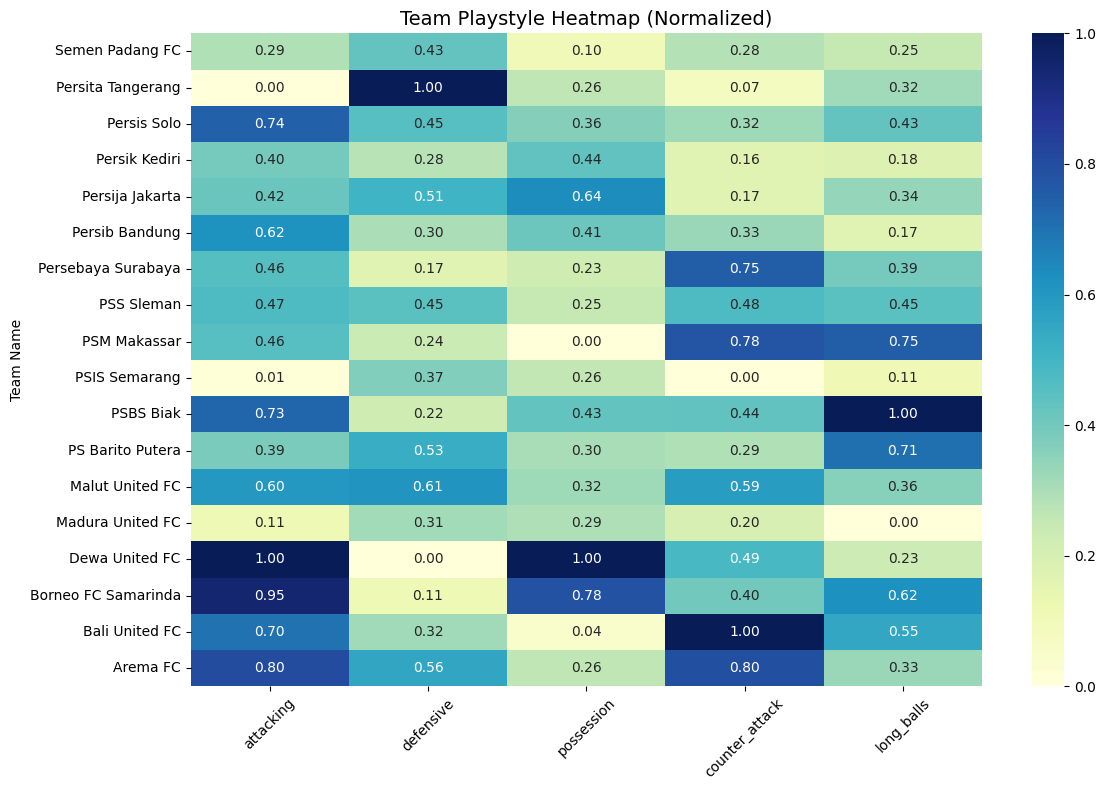

In [22]:
df_style = pd.DataFrame(index=dfp.index)

# Attacking
df_style['attacking'] = (
    dfp['Goals'] +
    dfp['Goal Assist'] +
    dfp['Key Pass'] +
    dfp['Expected Goals'] +
    dfp['Shot Percentage'] +
    dfp['On Target'] +
    dfp['Shot Off Target']
)

# Defensive
df_style['defensive'] = (
    dfp['Total Tackle'] +
    dfp['Interception'] +
    dfp['Total Clearance'] +
    dfp['Blocked'] +
    dfp['Defensive Actions'] +
    dfp['Aerial Won'] -
    dfp['Challenge Lost'] -
    dfp['Duel Lost']
)

# Possession
df_style['possession'] = (
    dfp['Passing Percentage'] +
    dfp['Total Pass'] +
    dfp['Accurate Pass'] +
    dfp['Touches'] -
    dfp['Possession Lost Control']
)

# Counter Attack (effisiensi serangan)
df_style['counter_attack'] = (dfp['Expected Goals'] / dfp['Touches']) * 1000

# Long Balls
df_style['long_balls'] = (
    dfp['Total Long Balls'] +
    dfp['Accurate Long Balls'] +
    dfp['Total Cross'] +
    dfp['Accurate Cross']
)

# Normalisasi semua kolom agar skala 0-1
scaler = MinMaxScaler()
df_style_scaled = pd.DataFrame(scaler.fit_transform(df_style), columns=df_style.columns, index=df_style.index)

print(df_style_scaled.head())

#viz
plt.figure(figsize=(12, 8))
sns.heatmap(df_style_scaled, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Team Playstyle Heatmap (Normalized)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


In [23]:
df_style_scaled['playstyle'] = df_style_scaled.idxmax(axis=1)

df_style_scaled

,attacking,defensive,possession,counter_attack,long_balls,playstyle
Team Name,,,,,,
Semen Padang FC,0.290171,0.425899,0.102088,0.281280,0.252485,defensive
Persita Tangerang,0.000000,1.000000,0.262088,0.074618,0.320080,defensive
Persis Solo,0.744291,0.454676,0.364841,0.322188,0.428429,attacking
Persik Kediri,0.395583,0.279137,0.435216,0.164512,0.179920,possession
Persija Jakarta,0.419828,0.506475,0.636606,0.166570,0.335984,possession
Persib Bandung,0.617860,0.300719,0.411962,0.329752,0.166004,attacking
Persebaya Surabaya,0.458681,0.169784,0.225314,0.751670,0.394632,counter_attack
PSS Sleman,0.473957,0.446043,0.250350,0.475713,0.447316,counter_attack
PSM Makassar,0.455773,0.237410,0.000000,0.776566,0.753479,counter_attack


In [24]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

playstyle_columns = ['attacking', 'defensive', 'possession', 'counter_attack', 'long_balls']
playstyle_df = df_style_scaled[playstyle_columns]

scaler = MinMaxScaler()
playstyle_scaled = scaler.fit_transform(playstyle_df)
playstyle_scaled_df = pd.DataFrame(playstyle_scaled, index=playstyle_df.index, columns=playstyle_columns)

similarity_df = pd.DataFrame(cosine_similarity(playstyle_scaled_df),
                              index=playstyle_df.index,
                              columns=playstyle_df.index)
similarity_df

Team Name,Semen Padang FC,Persita Tangerang,Persis Solo,Persik Kediri,Persija Jakarta,Persib Bandung,Persebaya Surabaya,PSS Sleman,PSM Makassar,PSIS Semarang,PSBS Biak,PS Barito Putera,Malut United FC,Madura United FC,Dewa United FC,Borneo FC Samarinda,Bali United FC,Arema FC
Team Name,,,,,,,,,,,,,,,,,,
Semen Padang FC,1.000000,0.789752,0.917921,0.821938,0.834342,0.847879,0.829112,0.970089,0.828152,0.713909,0.802112,0.924395,0.975822,0.800410,0.600104,0.721594,0.856148,0.935170
Persita Tangerang,0.789752,1.000000,0.603485,0.614075,0.739232,0.508327,0.377088,0.666144,0.412906,0.939504,0.453917,0.751089,0.688080,0.769175,0.227264,0.349709,0.387979,0.549171
Persis Solo,0.917921,0.603485,1.000000,0.940046,0.904635,0.964044,0.834726,0.955261,0.783639,0.626720,0.902228,0.905883,0.952964,0.751446,0.830297,0.919163,0.827469,0.931134
Persik Kediri,0.821938,0.614075,0.940046,1.000000,0.977690,0.964983,0.746280,0.872887,0.612322,0.739329,0.813317,0.830619,0.892057,0.864795,0.905581,0.924451,0.675365,0.842376
Persija Jakarta,0.834342,0.739232,0.904635,0.977690,1.000000,0.899127,0.683503,0.861077,0.585726,0.853860,0.797043,0.873455,0.870732,0.885480,0.812083,0.863090,0.610696,0.784024
Persib Bandung,0.847879,0.508327,0.964044,0.964983,0.899127,1.000000,0.835134,0.903274,0.694762,0.588257,0.815626,0.793308,0.931300,0.815705,0.920352,0.927342,0.794762,0.929179
Persebaya Surabaya,0.829112,0.377088,0.834726,0.746280,0.683503,0.835134,1.000000,0.920034,0.938686,0.361630,0.847648,0.788730,0.899066,0.653643,0.749969,0.812584,0.977361,0.935915
PSS Sleman,0.970089,0.666144,0.955261,0.872887,0.861077,0.903274,0.920034,1.000000,0.898651,0.639079,0.904114,0.945744,0.985681,0.776700,0.732984,0.846217,0.916613,0.961904
PSM Makassar,0.828152,0.412906,0.783639,0.612322,0.585726,0.694762,0.938686,0.898651,1.000000,0.316602,0.881297,0.842669,0.835685,0.479415,0.556447,0.717507,0.961942,0.857288


In [25]:
playstyle_scaled_df

,attacking,defensive,possession,counter_attack,long_balls
Team Name,,,,,
Semen Padang FC,0.290171,0.425899,0.102088,0.281280,0.252485
Persita Tangerang,0.000000,1.000000,0.262088,0.074618,0.320080
Persis Solo,0.744291,0.454676,0.364841,0.322188,0.428429
Persik Kediri,0.395583,0.279137,0.435216,0.164512,0.179920
Persija Jakarta,0.419828,0.506475,0.636606,0.166570,0.335984
Persib Bandung,0.617860,0.300719,0.411962,0.329752,0.166004
Persebaya Surabaya,0.458681,0.169784,0.225314,0.751670,0.394632
PSS Sleman,0.473957,0.446043,0.250350,0.475713,0.447316
PSM Makassar,0.455773,0.237410,0.000000,0.776566,0.753479


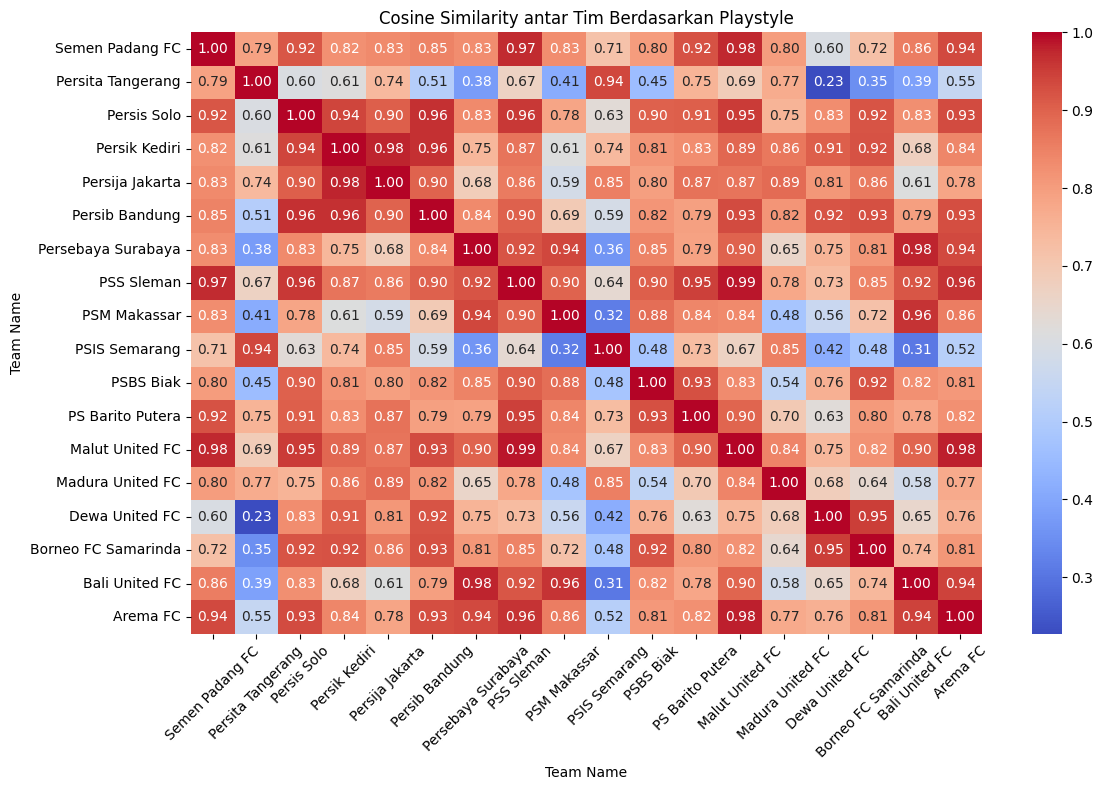

In [26]:
plt.figure(figsize=(12, 8))
sns.heatmap(similarity_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Cosine Similarity antar Tim Berdasarkan Playstyle")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## KMeans

In [27]:
from sklearn.cluster import KMeans

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:8

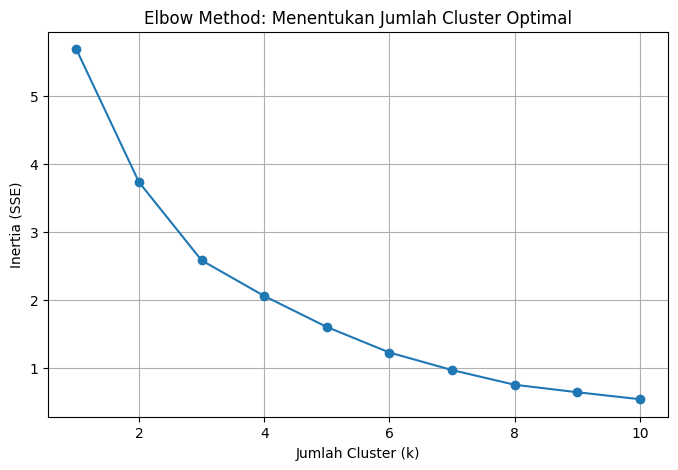

[5.6808095358606945, 3.729551452502487, 2.581645393129709, 2.0582835140888163, 1.6036188281368413, 1.2283434172025203, 0.9707698729398364, 0.7552645527407092, 0.6452948892479173, 0.5429065819313312]


In [28]:
# hitung inertia untuk berbagai jumlah cluster
inertias = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(playstyle_scaled_df)
    inertias.append(kmeans.inertia_)  # inertia = within-cluster sum of square (SSE)

# visualisasi elbow plot
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertias, marker='o')
plt.title('Elbow Method: Menentukan Jumlah Cluster Optimal')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia (SSE)')
plt.grid(True)
plt.show()

print(inertias)

In [29]:
kmeans = KMeans(n_clusters=4, random_state=42)
playstyle_scaled_df['playstyle_cluster'] = kmeans.fit_predict(playstyle_scaled_df)

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [30]:
playstyle_scaled_df.groupby('playstyle_cluster').mean()


,attacking,defensive,possession,counter_attack,long_balls
playstyle_cluster,,,,,
0,0.587039,0.237410,0.174299,0.741253,0.675199
1,0.604259,0.483213,0.319566,0.467100,0.407058
2,0.974698,0.056115,0.891572,0.442165,0.427435
3,0.204365,0.483213,0.331518,0.147405,0.200298


In [31]:
df_pca = playstyle_scaled_df.copy()
df_pca = df_pca.reset_index()

df_pca

,Team Name,attacking,defensive,possession,counter_attack,long_balls,playstyle_cluster
0,Semen Padang FC,0.290171,0.425899,0.102088,0.281280,0.252485,3
1,Persita Tangerang,0.000000,1.000000,0.262088,0.074618,0.320080,3
2,Persis Solo,0.744291,0.454676,0.364841,0.322188,0.428429,1
3,Persik Kediri,0.395583,0.279137,0.435216,0.164512,0.179920,3
4,Persija Jakarta,0.419828,0.506475,0.636606,0.166570,0.335984,3
5,Persib Bandung,0.617860,0.300719,0.411962,0.329752,0.166004,1
6,Persebaya Surabaya,0.458681,0.169784,0.225314,0.751670,0.394632,0
7,PSS Sleman,0.473957,0.446043,0.250350,0.475713,0.447316,1
8,PSM Makassar,0.455773,0.237410,0.000000,0.776566,0.753479,0
9,PSIS Semarang,0.008480,0.374101,0.259974,0.000000,0.113320,3


## PCA

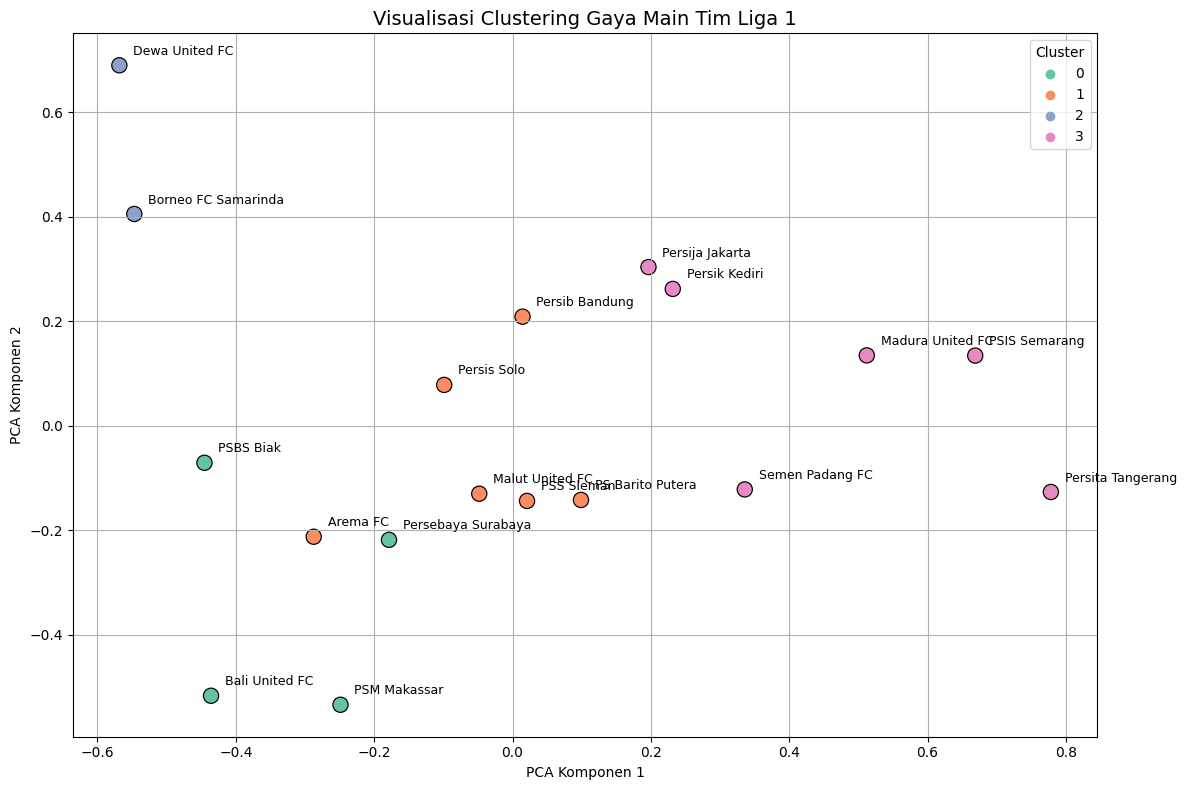

In [32]:
from sklearn.decomposition import PCA

# Ambil hanya kolom playstyle (5 fitur)
playstyle_features = ['attacking', 'defensive', 'possession', 'counter_attack', 'long_balls']
X = df_pca[playstyle_features]

# PCA ke 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Simpan ke DataFrame
df_pca['pca_1'] = X_pca[:, 0]
df_pca['pca_2'] = X_pca[:, 1]

# Scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_pca,
    x='pca_1',
    y='pca_2',
    hue='playstyle_cluster',
    palette='Set2',
    s=120,
    edgecolor='black'
)

# Tambahkan label nama tim ke tiap titik
for i in range(df_pca.shape[0]):
    plt.text(
        df_pca['pca_1'][i] + 0.02,
        df_pca['pca_2'][i] + 0.02,
        df_pca['Team Name'][i],
        fontsize=9
    )

plt.title("Visualisasi Clustering Gaya Main Tim Liga 1", fontsize=14)
plt.xlabel("PCA Komponen 1")
plt.ylabel("PCA Komponen 2")
plt.grid(True)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


In [33]:
df_pca

,Team Name,attacking,defensive,possession,counter_attack,long_balls,playstyle_cluster,pca_1,pca_2
0,Semen Padang FC,0.290171,0.425899,0.102088,0.281280,0.252485,3,0.335763,-0.121778
1,Persita Tangerang,0.000000,1.000000,0.262088,0.074618,0.320080,3,0.778349,-0.126686
2,Persis Solo,0.744291,0.454676,0.364841,0.322188,0.428429,1,-0.098793,0.078133
3,Persik Kediri,0.395583,0.279137,0.435216,0.164512,0.179920,3,0.231693,0.261753
4,Persija Jakarta,0.419828,0.506475,0.636606,0.166570,0.335984,3,0.196560,0.303574
5,Persib Bandung,0.617860,0.300719,0.411962,0.329752,0.166004,1,0.014500,0.208652
6,Persebaya Surabaya,0.458681,0.169784,0.225314,0.751670,0.394632,0,-0.178588,-0.218183
7,PSS Sleman,0.473957,0.446043,0.250350,0.475713,0.447316,1,0.020989,-0.143759
8,PSM Makassar,0.455773,0.237410,0.000000,0.776566,0.753479,0,-0.248718,-0.533654
9,PSIS Semarang,0.008480,0.374101,0.259974,0.000000,0.113320,3,0.668961,0.134208


In [34]:
# Bikin mapping dari nama tim ke cluster
cluster_map = df_pca.set_index('Team Name')['playstyle_cluster'].to_dict()

match_df = df.copy()

# Gunakan mapping untuk assign cluster ke home dan away
match_df['home_cluster'] = match_df['homeTeam_name'].map(cluster_map)
match_df['away_cluster'] = match_df['awayTeam_name'].map(cluster_map)

match_df

,match_id,match_date,team_home_id,homeTeam_name,team_away_id,awayTeam_name,home_goals,away_goals,match_id_1,possession_home,...,point_last5_home,point_last5_away,leaguePoint_home,leaguePoint_away,venue_island,venue_distance_km,pi_rating_home,pi_rating_away,home_cluster,away_cluster
0,12654006,2025-04-13,86576,Persita Tangerang,86542,PS Barito Putera,2.0,1.0,12654006.0,46.0,...,1,7,36,29,Jawa,937.391318,-0.195651,-0.102359,3,1
1,12654007,2025-04-12,200020,Persis Solo,491968,Malut United FC,1.0,3.0,12654007.0,56.0,...,9,11,23,43,Jawa,2120.312763,-0.195487,0.340124,1,1
2,12653997,2025-04-12,64295,Persija Jakarta,76319,Persebaya Surabaya,1.0,1.0,12653997.0,64.0,...,1,10,40,48,Jawa,662.571783,0.040962,0.092979,3,0
3,12654003,2025-04-11,189471,PSIS Semarang,135866,Persik Kediri,0.0,0.0,12654003.0,48.0,...,3,3,24,35,Jawa,199.597101,-0.349868,-0.158247,3,3
4,12654000,2025-04-11,266861,PSBS Biak,204733,PSS Sleman,2.0,1.0,12654000.0,55.0,...,8,3,37,25,Papua,2965.216902,0.083611,-0.414688,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,12652787,2024-08-11,135866,Persik Kediri,64299,Bali United FC,1.0,3.0,12652787.0,63.0,...,0,0,0,0,Jawa,355.963270,0.000000,0.000000,3,0
244,12652782,2024-08-10,86578,Madura United FC,491968,Malut United FC,1.0,1.0,12652782.0,60.0,...,0,0,0,0,Jawa,1860.457150,0.000000,0.000000,3,1
245,12652781,2024-08-10,64295,Persija Jakarta,86542,PS Barito Putera,3.0,0.0,12652781.0,57.0,...,0,0,0,0,Jawa,916.315735,0.000000,0.000000,3,1
246,12652783,2024-08-10,135864,PSM Makassar,200020,Persis Solo,3.0,0.0,12652783.0,45.0,...,0,0,0,0,Sulawesi,989.486553,0.000000,0.000000,0,1


In [35]:
# match_df = df.copy() 

# # Tambahkan cluster playstyle
# match_df['home_cluster'] = match_df['homeTeam_name'].map(df_pca['playstyle_cluster'])
# match_df['away_cluster'] = match_df['awayTeam_name'].map(df_pca['playstyle_cluster'])

# # Cek nama-nama tim yang gak ketemu
# home_teams_not_found = set(match_df['homeTeam_name']) - set(df_pca['Team Name'])
# away_teams_not_found = set(match_df['awayTeam_name']) - set(df_pca['Team Name'])

# print("Home teams not matched:", home_teams_not_found)
# print("Away teams not matched:", away_teams_not_found)


# match_df

In [36]:
match_df['winner'] = match_df['result'].map({'H': -1, 'D': 0, 'A': 1})
cluster_match_result = (
    match_df.groupby(['home_cluster', 'away_cluster'])['winner']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

cluster_match_result

winner                           -1         0         1
home_cluster away_cluster                              
0            0             0.333333  0.333333  0.333333
             1             0.500000  0.350000  0.150000
             2             0.750000  0.250000  0.000000
             3             0.526316  0.315789  0.157895
1            0             0.473684  0.263158  0.263158
             1             0.333333  0.208333  0.458333
             2             0.333333  0.444444  0.222222
             3             0.413793  0.241379  0.344828
2            0             1.000000  0.000000  0.000000
             1             0.636364  0.272727  0.090909
             2             0.500000  0.000000  0.500000
             3             0.400000  0.300000  0.300000
3            0             0.190476  0.428571  0.380952
             1             0.266667  0.333333  0.400000
             2             0.111111  0.222222  0.666667
             3             0.565217  0.130435  0.304348

In [37]:
match_df

,match_id,match_date,team_home_id,homeTeam_name,team_away_id,awayTeam_name,home_goals,away_goals,match_id_1,possession_home,...,point_last5_away,leaguePoint_home,leaguePoint_away,venue_island,venue_distance_km,pi_rating_home,pi_rating_away,home_cluster,away_cluster,winner
0,12654006,2025-04-13,86576,Persita Tangerang,86542,PS Barito Putera,2.0,1.0,12654006.0,46.0,...,7,36,29,Jawa,937.391318,-0.195651,-0.102359,3,1,-1
1,12654007,2025-04-12,200020,Persis Solo,491968,Malut United FC,1.0,3.0,12654007.0,56.0,...,11,23,43,Jawa,2120.312763,-0.195487,0.340124,1,1,1
2,12653997,2025-04-12,64295,Persija Jakarta,76319,Persebaya Surabaya,1.0,1.0,12653997.0,64.0,...,10,40,48,Jawa,662.571783,0.040962,0.092979,3,0,0
3,12654003,2025-04-11,189471,PSIS Semarang,135866,Persik Kediri,0.0,0.0,12654003.0,48.0,...,3,24,35,Jawa,199.597101,-0.349868,-0.158247,3,3,0
4,12654000,2025-04-11,266861,PSBS Biak,204733,PSS Sleman,2.0,1.0,12654000.0,55.0,...,3,37,25,Papua,2965.216902,0.083611,-0.414688,0,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,12652787,2024-08-11,135866,Persik Kediri,64299,Bali United FC,1.0,3.0,12652787.0,63.0,...,0,0,0,Jawa,355.963270,0.000000,0.000000,3,0,1
244,12652782,2024-08-10,86578,Madura United FC,491968,Malut United FC,1.0,1.0,12652782.0,60.0,...,0,0,0,Jawa,1860.457150,0.000000,0.000000,3,1,0
245,12652781,2024-08-10,64295,Persija Jakarta,86542,PS Barito Putera,3.0,0.0,12652781.0,57.0,...,0,0,0,Jawa,916.315735,0.000000,0.000000,3,1,-1
246,12652783,2024-08-10,135864,PSM Makassar,200020,Persis Solo,3.0,0.0,12652783.0,45.0,...,0,0,0,Sulawesi,989.486553,0.000000,0.000000,0,1,-1


### save to sv

In [38]:
# match_df.to_csv('/kaggle/working/siapTrain_v4_with cluster')

In [39]:
match_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 55 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   match_id              248 non-null    int64         
 1   match_date            248 non-null    datetime64[ns]
 2   team_home_id          248 non-null    int64         
 3   homeTeam_name         248 non-null    object        
 4   team_away_id          248 non-null    int64         
 5   awayTeam_name         248 non-null    object        
 6   home_goals            248 non-null    float64       
 7   away_goals            248 non-null    float64       
 8   match_id_1            243 non-null    float64       
 9   possession_home       243 non-null    float64       
 10  possession_away       243 non-null    float64       
 11  passes_home           243 non-null    float64       
 12  passes_away           243 non-null    float64       
 13  accuratePasses_home 

In [40]:
dfc = match_df[['match_id', 'homeTeam_name', 'awayTeam_name', 'home_cluster', 'away_cluster']]

dfc.head()

,match_id,homeTeam_name,awayTeam_name,home_cluster,away_cluster
0,12654006,Persita Tangerang,PS Barito Putera,3,1
1,12654007,Persis Solo,Malut United FC,1,1
2,12653997,Persija Jakarta,Persebaya Surabaya,3,0
3,12654003,PSIS Semarang,Persik Kediri,3,3
4,12654000,PSBS Biak,PSS Sleman,0,1


In [41]:
def predict_match_result(home_team, away_team, team_cluster_map, cluster_match_result):
    h_cluster = team_cluster_map[home_team]
    a_cluster = team_cluster_map[away_team]
    
    try:
        probs = cluster_match_result.loc[(h_cluster, a_cluster)]
        pred_result = probs.idxmax()  # -1, 0, atau 1
        return {
            'Home Cluster': h_cluster,
            'Away Cluster': a_cluster,
            'Win Probability': probs[1],
            'Draw Probability': probs[0],
            'Lose Probability': probs[-1],
            'Prediction': {1: 'Home Win', 0: 'Draw', -1: 'Away Win'}[pred_result]
        }
    except KeyError:
        return "Matchup cluster ini belum ada di data historis"


In [42]:
dfc

,match_id,homeTeam_name,awayTeam_name,home_cluster,away_cluster
0,12654006,Persita Tangerang,PS Barito Putera,3,1
1,12654007,Persis Solo,Malut United FC,1,1
2,12653997,Persija Jakarta,Persebaya Surabaya,3,0
3,12654003,PSIS Semarang,Persik Kediri,3,3
4,12654000,PSBS Biak,PSS Sleman,0,1
...,...,...,...,...,...
243,12652787,Persik Kediri,Bali United FC,3,0
244,12652782,Madura United FC,Malut United FC,3,1
245,12652781,Persija Jakarta,PS Barito Putera,3,1
246,12652783,PSM Makassar,Persis Solo,0,1


In [43]:
df_pca

,Team Name,attacking,defensive,possession,counter_attack,long_balls,playstyle_cluster,pca_1,pca_2
0,Semen Padang FC,0.290171,0.425899,0.102088,0.281280,0.252485,3,0.335763,-0.121778
1,Persita Tangerang,0.000000,1.000000,0.262088,0.074618,0.320080,3,0.778349,-0.126686
2,Persis Solo,0.744291,0.454676,0.364841,0.322188,0.428429,1,-0.098793,0.078133
3,Persik Kediri,0.395583,0.279137,0.435216,0.164512,0.179920,3,0.231693,0.261753
4,Persija Jakarta,0.419828,0.506475,0.636606,0.166570,0.335984,3,0.196560,0.303574
5,Persib Bandung,0.617860,0.300719,0.411962,0.329752,0.166004,1,0.014500,0.208652
6,Persebaya Surabaya,0.458681,0.169784,0.225314,0.751670,0.394632,0,-0.178588,-0.218183
7,PSS Sleman,0.473957,0.446043,0.250350,0.475713,0.447316,1,0.020989,-0.143759
8,PSM Makassar,0.455773,0.237410,0.000000,0.776566,0.753479,0,-0.248718,-0.533654
9,PSIS Semarang,0.008480,0.374101,0.259974,0.000000,0.113320,3,0.668961,0.134208


In [44]:
def create_rolling_features_auto(match_df, base_columns, n_matches=3, agg='mean', team_home_col='team_home', team_away_col='team_away'):
    """
    Otomatis bikin rolling feature utk kolom *_home dan *_away dengan nama kolom tim yg bisa dikustom.
    """
    match_df = match_df.copy()
    match_df['match_date'] = pd.to_datetime(match_df['match_date'])
    match_df = match_df.sort_values(by='match_date')

    for base_col in base_columns:
        for side in ['home', 'away']:
            col_name = f'{base_col}_{side}'
            team_col = team_home_col if side == 'home' else team_away_col
            new_col = f'{base_col}_{side}_last{n_matches}_{agg}'

            if col_name in match_df.columns and team_col in match_df.columns:
                match_df[new_col] = (
                    match_df.groupby(match_df[team_col])[col_name]
                    .transform(lambda x: x.shift(1).rolling(n_matches, min_periods=1).agg(agg))
                )
            else:
                print(f"⚠️ Kolom '{col_name}' atau '{team_col}' nggak ada di dataframe. Skip.")

    return match_df
base_columns = ['possession', 'xG', 'rating', 'goal_contrib', 'interceptions', 'passes', 'dribblesPct','corners','avg_rating']

match_df = create_rolling_features_auto(
    match_df,
    base_columns=base_columns,
    n_matches=3,
    agg='mean',
    team_home_col='homeTeam_name',
    team_away_col='awayTeam_name'  # pastikan ini bener, ya
)

match_df

⚠️ Kolom 'rating_home' atau 'homeTeam_name' nggak ada di dataframe. Skip.
⚠️ Kolom 'rating_away' atau 'awayTeam_name' nggak ada di dataframe. Skip.


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,match_id,match_date,team_home_id,homeTeam_name,team_away_id,awayTeam_name,home_goals,away_goals,match_id_1,possession_home,...,interceptions_home_last3_mean,interceptions_away_last3_mean,passes_home_last3_mean,passes_away_last3_mean,dribblesPct_home_last3_mean,dribblesPct_away_last3_mean,corners_home_last3_mean,corners_away_last3_mean,avg_rating_home_last3_mean,avg_rating_away_last3_mean
247,12652779,2024-08-09,64289,Persib Bandung,266861,PSBS Biak,4.0,1.0,12652779.0,40.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
244,12652782,2024-08-10,86578,Madura United FC,491968,Malut United FC,1.0,1.0,12652782.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,12652783,2024-08-10,135864,PSM Makassar,200020,Persis Solo,3.0,0.0,12652783.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,12652781,2024-08-10,64295,Persija Jakarta,86542,PS Barito Putera,3.0,0.0,12652781.0,57.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241,12652786,2024-08-11,189471,PSIS Semarang,86576,Persita Tangerang,0.0,1.0,12652786.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,12654000,2025-04-11,266861,PSBS Biak,204733,PSS Sleman,2.0,1.0,12654000.0,55.0,...,14.666667,15.000000,363.333333,277.333333,28.000000,12.333333,6.333333,2.666667,4.686059,5.520468
3,12654003,2025-04-11,189471,PSIS Semarang,135866,Persik Kediri,0.0,0.0,12654003.0,48.0,...,9.000000,13.000000,420.666667,364.000000,17.000000,19.666667,5.000000,4.666667,4.660870,5.099697
2,12653997,2025-04-12,64295,Persija Jakarta,76319,Persebaya Surabaya,1.0,1.0,12653997.0,64.0,...,11.666667,17.666667,349.666667,276.333333,12.333333,11.666667,5.666667,4.333333,4.857431,4.630317
1,12654007,2025-04-12,200020,Persis Solo,491968,Malut United FC,1.0,3.0,12654007.0,56.0,...,15.333333,17.000000,394.000000,292.666667,18.000000,13.666667,7.333333,3.000000,4.555072,4.734783


In [45]:
match_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 248 entries, 247 to 0
Data columns (total 71 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   match_id                       248 non-null    int64         
 1   match_date                     248 non-null    datetime64[ns]
 2   team_home_id                   248 non-null    int64         
 3   homeTeam_name                  248 non-null    object        
 4   team_away_id                   248 non-null    int64         
 5   awayTeam_name                  248 non-null    object        
 6   home_goals                     248 non-null    float64       
 7   away_goals                     248 non-null    float64       
 8   match_id_1                     243 non-null    float64       
 9   possession_home                243 non-null    float64       
 10  possession_away                243 non-null    float64       
 11  passes_home             